In [67]:
import cv2 as cv 
import matplotlib.pyplot as plt  
import numpy as np

In [68]:
colors_dict = {
    'negro': [0, 0, 0],
    'blanco': [255, 255, 255],
    'rojo': [255, 0, 0],
    'verde': [0, 255, 0],
    'azul': [0, 0, 255],
    'amarillo': [255, 255, 0],
    'magenta': [255, 0, 255],
    'cyan': [0, 255, 255],
    #'gris': [128, 128, 128]
}

In [78]:
def R_measure(image):

    norm_var = image.var()/255 # Obtenemos la varianza de la imagen y la normalizamos
    R = 1 - (1 / (1 + norm_var)) # Aplicamos la fórmula para calcular R a partir de la varianza normalizada

    return R

In [80]:
def segment_car_by_color(image, color_name, hue_tolerance = 25, k = 10):

    print(R_measure(image))
    
    def get_mask(target_color_hsv, hue_tolerance):

        if color_name.lower() == 'negro':
            lower = np.array([0, 0, 0])
            upper = np.array([179, 255, 50])
            full_mask = cv.inRange(hsv, lower, upper)
            return full_mask
        elif color_name.lower() == 'blanco':
            lower = np.array([0, 0, 200])
            upper = np.array([179, 30, 255])
            full_mask = cv.inRange(hsv, lower, upper)
            return full_mask
        elif color_name.lower() == 'gris':
            lower = np.array([0, 0, 100])
            upper = np.array([179, 30, 200])
            full_mask = cv.inRange(hsv, lower, upper)
            return full_mask
        
        lower_hue = target_color_hsv[0][0][0] - hue_tolerance
        upper_hue = target_color_hsv[0][0][0] + hue_tolerance
            
        if lower_hue < 0:
            lower1 = np.array([0, 100, 100])
            upper1 = np.array([upper_hue, 255, 255])
            
            lower2 = np.array([179 + lower_hue, 100, 100])
            upper2 = np.array([179, 255, 255])
            
            lower_mask = cv.inRange(hsv, lower1, upper1)
            upper_mask = cv.inRange(hsv, lower2, upper2)
            full_mask = lower_mask + upper_mask
            
        elif upper_hue > 179:
            
            lower1 = np.array([0, 100, 100])
            upper1 = np.array([upper_hue - 179, 255, 255])
            
            lower2 = np.array([lower_hue, 100, 100])
            upper2 = np.array([179, 255, 255])
            
            lower_mask = cv.inRange(hsv, lower1, upper1)
            upper_mask = cv.inRange(hsv, lower2, upper2)
            full_mask = lower_mask + upper_mask
            
            
        else: # lower_hue >= 0 and upper_hue <= 179
        
            lower = np.array([lower_hue, 100, 100])
            upper = np.array([upper_hue, 255, 255])
            full_mask = cv.inRange(hsv, lower, upper)
            
        return full_mask
    
    target_color = colors_dict[color_name.lower()]
    
    # Convertir la imagen a RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Convertir la imagen a valores de píxeles individuales
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Realizar K-means clustering para encontrar los centros de los colores similares al objetivo
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    _, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # Convertir los centros a enteros sin signo de 8 bits y aplanar las etiquetas
    centers = np.uint8(centers)
    labels = labels.flatten()

    # Crear una imagen segmentada donde cada píxel está etiquetado con el centro más cercano
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    # Convertir la imagen segmentada a HSV
    hsv = cv.cvtColor(segmented_image, cv.COLOR_RGB2HSV)

    # Definir los límites superior e inferior del color objetivo en HSV
    target_color_hsv = cv.cvtColor(np.uint8([[target_color]]), cv.COLOR_RGB2HSV)

    full_mask = get_mask(target_color_hsv, hue_tolerance)
    
    # Aplicar la máscara a la imagen original
    # masked_image = cv.bitwise_and(segmented_image, segmented_image, mask=full_mask)
    
    contours, _ = cv.findContours(full_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        # Encontrar la caja delimitadora del contorno más grande y devolver la región recortada de la imagen original
        x, y, w, h = cv.boundingRect(largest_contour)
        return image[y:y+h, x:x+w]
    else:
        return None

## Pruebas experimentales

0.9581857515696701


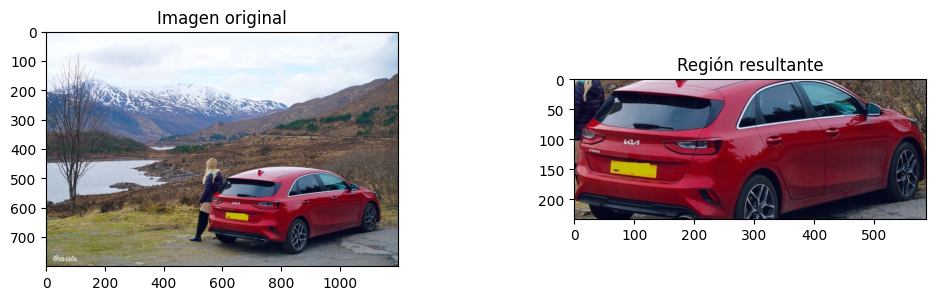

In [81]:
red_car = cv.imread('images/red_car.jpg')

car_region = segment_car_by_color(red_car, "rojo")

plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(red_car, cv.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Región resultante")
plt.imshow(car_region)

0.9286892537413977


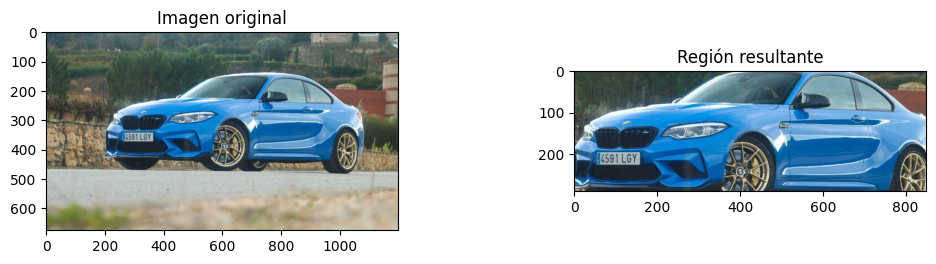

In [87]:
blue_car = cv.imread('images/blue_car.webp')

car_region = segment_car_by_color(blue_car, "azul")

plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(blue_car, cv.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Región resultante")
plt.imshow(car_region)

0.9377738667664254


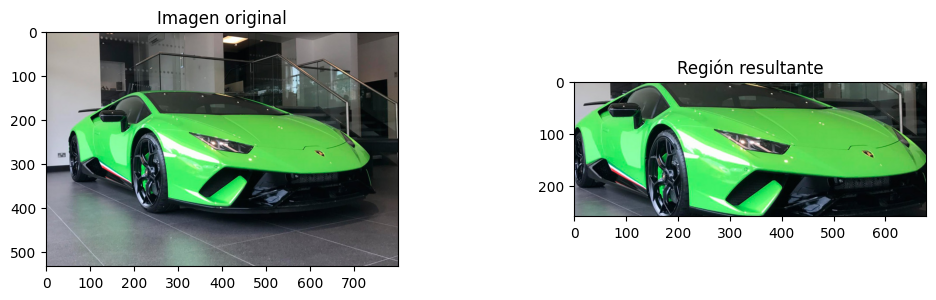

In [83]:
green_car = cv.imread('images/green_car.jpg')

car_region = segment_car_by_color(green_car, "verde")

plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(green_car, cv.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Región resultante")
plt.imshow(car_region)

0.9600751056118564


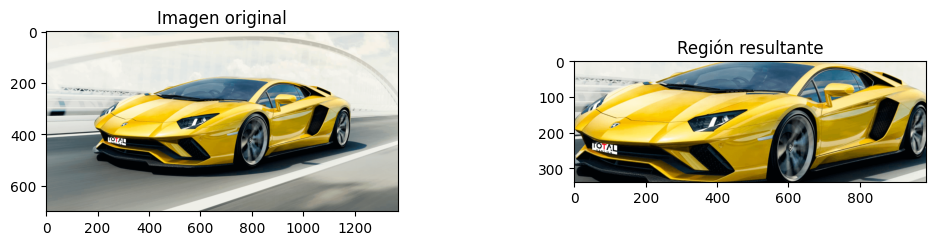

In [84]:
yellow_car = cv.imread('images/yellow_car.png')

car_region = segment_car_by_color(yellow_car, "amarillo", hue_tolerance = 25)

plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(yellow_car, cv.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Región resultante")
plt.imshow(car_region)

0.9394445176402522


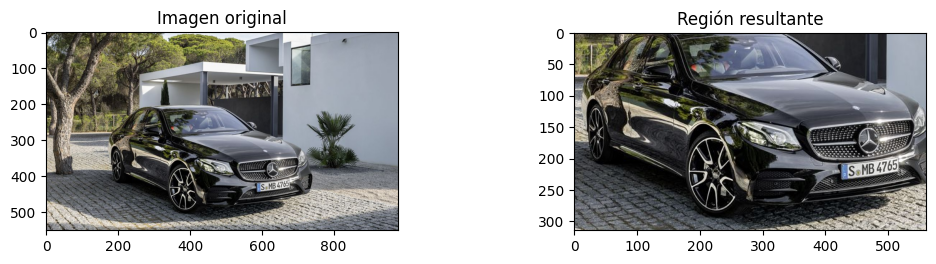

In [94]:
black_car = cv.imread('images/black_car.jpeg')

car_region = segment_car_by_color(black_car, "negro", hue_tolerance = 25)

plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(black_car, cv.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Región resultante")
plt.imshow(car_region)